In [34]:
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import UFF_decomposition as UFFd
import alchemy_tools2 as at
import explore_qml_data as eqd

import glob
import utils_qm as uqm

from matplotlib import pyplot as plt
import numpy as np

from ase.units import Bohr
from ase import Atoms
import ase.visualize

# Alchemical Energies

In [35]:
def get_data(data):
    e_npbc = []
    for d in data:
        e_npbc.append(d['e_nbpc'])
    e_npbc = np.array(e_npbc)
    
    e_scaled = []
    for d in data:
        e_scaled.append(d['e_scaled'])
    e_scaled = np.array(e_scaled)

    e_el = []
    for d in data:
        e_el.append(d['e_el'])
    e_el = np.array(e_el)

    e_tot = []
    for d in data:
        e_tot.append(d['e_tot'])
    e_tot = np.array(e_tot)

    alchpots = []
    for d, e in zip(data, e_el):
        alchpots.append(e/d['nuclei'][:,0])
    alchpots = np.array(alchpots)
    
    return(alchpots, e_el, e_npbc, e_scaled, e_tot)

In [42]:
zeff_bool = False
geom_type = 'dihedral'
box_length = 18.886527828347333

if geom_type == 'bond':
    paths_glob = glob.glob('/data/sahre/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/butanol/dist_*/results.dict')

elif geom_type == 'angle':    
    paths_glob = glob.glob('/data/sahre/projects/atomic-energies/data/ueg_reference/amons/geometry/angles/butanol_plane/ang*/results_full.dict')
#     paths_glob = glob.glob('/data/sahre/projects/atomic-energies/data/ueg_reference/amons/geometry/angles/butanol_plane/ang*/results.dict')
    
elif geom_type == 'dihedral':    
    paths_glob = glob.glob('/data/sahre/projects/atomic-energies/data/ueg_reference/amons/geometry/dihedral/butanol/dihe*/results.dict')

paths = uqm.sort_paths(paths_glob, -2, -1, '/','_')

data = []
for p in paths:
    data.append(uqm.load_obj(p))
    
geometries = dict()
nuc_repulsion = []
rcoord = []
zeff = np.array([4., 4, 4, 4, 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
for d in data:
    nuc_charges = d['nuclei'][:,0]
    pos = d['nuclei'][:,1:]*Bohr
    pos = eqd.shift2center(pos, [0,0,0])
    if zeff_bool:
        molecule = Atoms(numbers=zeff, positions=pos)
    else:
        molecule = Atoms(numbers=nuc_charges, positions=pos)
    
    if geom_type == 'bond':
        ang = np.round(molecule.get_distance(2,4), 5)
        geometries[f'd_{ang}'] = molecule
    elif geom_type == 'angle':
        ang = np.round(molecule.get_angle(1, 2,4))
        geometries[f'ang_{ang}'] = molecule
    elif geom_type == 'dihedral':
        ang = np.round(molecule.get_dihedral(4,2,1,0))
        geometries[f'dihe_{ang}'] = molecule
    rcoord.append(ang)
    
    nuc_repulsion.append(at.ewald_site(box_length, molecule))
    

nuc_repulsion = np.array(nuc_repulsion)
alchpots, e_el, e_npbc, e_scaled, e_tot = get_data(data)


In [44]:
# for k in geometries.keys():
#     ase.io.write(f'/data/sahre/projects/atomic-energies/data/UFF_energies/butanol_dihedral/{k}.xyz', geometries[k])

In [43]:
geometries

{'dihe_0.0': Atoms(symbols='C4OH10', pbc=False),
 'dihe_30.0': Atoms(symbols='C4OH10', pbc=False),
 'dihe_60.0': Atoms(symbols='C4OH10', pbc=False),
 'dihe_90.0': Atoms(symbols='C4OH10', pbc=False),
 'dihe_120.0': Atoms(symbols='C4OH10', pbc=False),
 'dihe_150.0': Atoms(symbols='C4OH10', pbc=False),
 'dihe_180.0': Atoms(symbols='C4OH10', pbc=False)}

In [ ]:
plt.plot(rcoord, (alchpots*zeff).sum(axis=1)+nuc_repulsion.sum(axis=1), '-o')

In [ ]:
np.amin((alchpots*zeff).sum(axis=1)+nuc_repulsion.sum(axis=1))-np.amax((alchpots*zeff).sum(axis=1)+nuc_repulsion.sum(axis=1))

In [ ]:
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [10,6]
fig, ax = plt.subplots(1,2)
for i in range(5):
    ax[0].plot(rcoord, (alchpots*zeff)[:,i], '-o', label = i)
    ax[1].plot(rcoord, nuc_repulsion[:,i], '-o', label = i)
#     ax[2].plot(rcoord, (alchpots*zeff)[:,i]+nuc_repulsion[:,i])
#     plt.plot(rcoord, (alchpots*zeff)[:,i])

ax[0].set_xlabel(r'r(CO) $(\AA)$')
ax[1].set_xlabel(r'r(CO) $(\AA)$')

ax[0].set_ylabel(r'$E_{\rm{el}}$ (Ha)')
ax[1].set_ylabel(r'$E_{\rm{nuc}}$ (Ha)')

fig.tight_layout()
ax[1].legend(bbox_to_anchor=(1.05, 1.0))

In [ ]:
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

for i in range(4):
    ax.plot(rcoord, (alchpots*zeff)[:,i]+nuc_repulsion[:,i], '-o',label=i)
ax2.plot(rcoord, (alchpots*zeff)[:,4]+nuc_repulsion[:,4], '-o', color='tab:purple',label='4')

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.legend(bbox_to_anchor=(1.05, 1.0))
ax2.legend(bbox_to_anchor=(1.25, 1.0))

ax.set_ylabel(r'$E_{\rm{tot}}$ (Ha)', loc='bottom')
ax2.set_xlabel(r'r(CO) $(\AA)$')

# ax[1].set_ylabel(r'$E_{\rm{nuc}}$')

# UFF energies

In [84]:
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import UFF_decomposition as UFFd

import glob
import utils_qm as uqm

from matplotlib import pyplot as plt
import numpy as np

import ase
import ase.visualize

from natsort import natsorted

In [85]:
geom_type = 'angle'


In [86]:
if geom_type == 'bond':
    outfiles = glob.glob('/data/sahre/projects/atomic-energies/data/UFF_energies/butanol_bond/out*')
    outfiles.sort()
elif geom_type == 'angle':
    outfiles = glob.glob('/data/sahre/projects/atomic-energies/data/UFF_energies/butanol_angle/out*')
    outfiles=natsorted(outfiles)
elif geom_type == 'dihedral':
    outfiles = glob.glob('/data/sahre/projects/atomic-energies/data/UFF_energies/butanol_dihedral/out*')
    outfiles=natsorted(outfiles)

results = []

if geom_type == 'bond':
    for of in outfiles[:6]:
        results.append(UFFd.get_UFF_decomposition(of))
elif geom_type == 'angle':
    for of in outfiles[1:]:
        results.append(UFFd.get_UFF_decomposition(of))
elif geom_type == 'dihedral':
    for of in outfiles:
        results.append(UFFd.get_UFF_decomposition(of))
    
etot_UFF = []
atomic_energies = []
for r in results:
    etot_UFF.append(r['e_atomic'].sum())
    atomic_energies.append(r['e_atomic'])
atomic_energies= np.array(atomic_energies)*0.00038

if geom_type == 'bond':
    rcoord_UFF = [0.92429,
     1.04929,
     1.17429,
     1.29929,
     1.42429,
     1.67429]
elif geom_type == 'angle':
    rcoord_UFF = [70, 83, 95, 108, 120, 133, 145, 158]
elif geom_type == 'dihedral':
    rcoord_UFF = [0, 30, 60, 90, 120, 150, 180]

In [87]:
etot_UFF

[742.503, 268.885, 99.093, 41.482, 67.805, 165.727, 321.325, 522.0820000000001]

In [70]:
ase.visualize.view(Atoms(numbers=molecule.get_atomic_numbers(), positions=results[0]['position']))

<Popen: returncode: None args: ['/home/sahre/opt/miniconda3/envs/qm-tools/bi...>

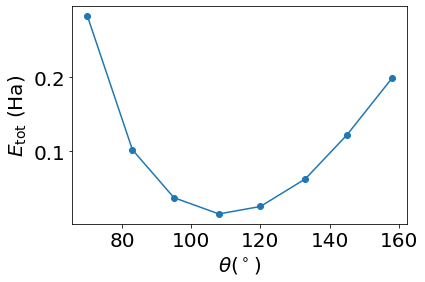

In [91]:
plt.rcParams['figure.figsize'] = [6,4]

plt.plot(rcoord_UFF, np.array(etot_UFF)*0.00038, '-o')
plt.ylabel(r'$E_{\rm{tot}}$ (Ha)')

if geom_type == 'bond':
    plt.xlabel(r'r(CO) $(\AA)$')

elif geom_type == 'angle':
    plt.xlabel(r'$\theta (^\circ)$')

# heavy atoms

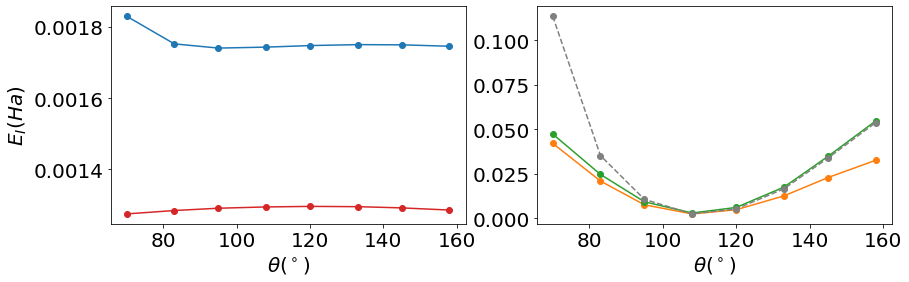

In [95]:
plt.rcParams['figure.figsize'] = [14,4]
fig, ax = plt.subplots(1,2)

if geom_type == 'bond':
    ax[0].plot(rcoord_UFF, atomic_energies[:,0], '-o',label='C0', color='tab:blue')
    ax[0].plot(rcoord_UFF, atomic_energies[:,1], '-o',label='C1', color='tab:orange')
    ax[0].plot(rcoord_UFF, atomic_energies[:,3], '-o',label='C3', color='tab:red')
    #ax[0].legend(bbox_to_anchor=(1.05,1))
    ax[0].set_xlabel(r'$d_{\rm{CO}}$ ($\AA$)')

    ax[0].set_ylabel(r'$E_I (Ha)$')

    ax[1].plot(rcoord_UFF, atomic_energies[:,2], '-o',label='C2', color='tab:green')
    ax[1].plot(rcoord_UFF, atomic_energies[:,4], '--o', label='O', color='grey')

    ax[1].set_xlabel(r'$d_{\rm{CO}}$ ($\AA$)')
    
if geom_type == 'angle':
    ax[0].plot(rcoord_UFF, atomic_energies[:,0], '-o',label='C0', color='tab:blue')
    ax[0].plot(rcoord_UFF, atomic_energies[:,3], '-o',label='C3', color='tab:red')
    #ax[0].legend(bbox_to_anchor=(1.05,1))
    ax[0].set_xlabel(r'$\theta (^\circ)$')

    ax[0].set_ylabel(r'$E_I (Ha)$')
    
    ax[1].plot(rcoord_UFF, atomic_energies[:,1], '-o',label='C1', color='tab:orange')
    ax[1].plot(rcoord_UFF, atomic_energies[:,2], '-o',label='C2', color='tab:green')
    ax[1].plot(rcoord_UFF, atomic_energies[:,4], '--o', label='O', color='grey')

    ax[1].set_xlabel(r'$\theta (^\circ)$')

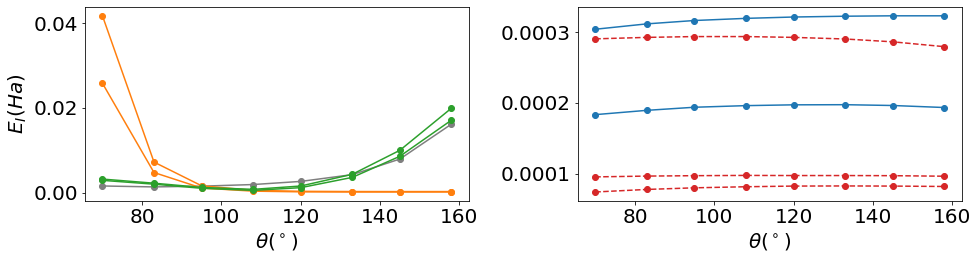

In [97]:
plt.rcParams['figure.figsize'] = [14,4]
fig, (ax, ax2) = plt.subplots(1,2)

if geom_type == 'bond':
    # O
    ax.plot(rcoord_UFF, atomic_energies[:,14], '-o', color='tab:grey')

    # C1
    ax.plot(rcoord_UFF, atomic_energies[:,7], '-o', color='tab:orange')
    ax.plot(rcoord_UFF, atomic_energies[:,8], '-o', color='tab:orange')
    # C2
    ax.plot(rcoord_UFF, atomic_energies[:,9], '-o', color='tab:green')
    ax.plot(rcoord_UFF, atomic_energies[:,10], '-o', color='tab:green')

    # Hydrogens
    # C0
    ax2.plot(rcoord_UFF, atomic_energies[:,5], '-o', color='tab:blue')
    ax2.plot(rcoord_UFF, atomic_energies[:,6], '-o', color='tab:blue')
    # C3
    ax2.plot(rcoord_UFF, atomic_energies[:,11], '--o', color='tab:red')
    ax2.plot(rcoord_UFF, atomic_energies[:,12], '--o', color='tab:red')
    ax2.plot(rcoord_UFF, atomic_energies[:,13], '--o', color='tab:red')
    
    ax.set_xlabel(r'$d_{\rm{CO}}$ ($\AA$)')

    ax.set_ylabel(r'$E_I (Ha)$')

    ax2.set_xlabel(r'$d_{\rm{CO}}$ ($\AA$)')
    
if geom_type == 'angle':
    # O
    ax.plot(rcoord_UFF, atomic_energies[:,14], '-o', color='tab:grey')

    # C1
    ax.plot(rcoord_UFF, atomic_energies[:,7], '-o', color='tab:orange')
    ax.plot(rcoord_UFF, atomic_energies[:,8], '-o', color='tab:orange')
    # C2
    ax.plot(rcoord_UFF, atomic_energies[:,9], '-o', color='tab:green')
    ax.plot(rcoord_UFF, atomic_energies[:,10], '-o', color='tab:green')

    # Hydrogens
    # C0
    ax2.plot(rcoord_UFF, atomic_energies[:,5], '-o', color='tab:blue')
    ax2.plot(rcoord_UFF, atomic_energies[:,6], '-o', color='tab:blue')
    # C3
    ax2.plot(rcoord_UFF, atomic_energies[:,11], '--o', color='tab:red')
    ax2.plot(rcoord_UFF, atomic_energies[:,12], '--o', color='tab:red')
    ax2.plot(rcoord_UFF, atomic_energies[:,13], '--o', color='tab:red')
    
    ax.set_xlabel(r'$\theta (^\circ)$')

    ax.set_ylabel(r'$E_I (Ha)$')

    ax2.set_xlabel(r'$\theta (^\circ)$')
fig.tight_layout()



Text(0.5, 0, 'r(CO) $(\\AA)$')

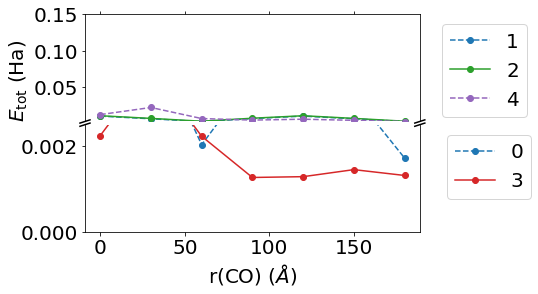

In [57]:
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.03)  # adjust space between axes

plt.rcParams['font.size'] = 20

ax2.plot(rcoord_UFF,np.array(atomic_energies)[:,0], '--o',label='0')
ax.plot(rcoord_UFF,np.array(atomic_energies)[:,1], '--o',label='1')
ax2.plot(rcoord_UFF,np.array(atomic_energies)[:,3], '-o', color = 'tab:red', label='3')
    
# plt.xlabel('r(CO) (Ang)')
# plt.ylabel('E (Ha)')
# plt.legend()
# plt.legend(bbox_to_anchor=(1.0, 1.05))

ax.plot(rcoord_UFF,np.array(atomic_energies)[:,2], '-o', color = 'tab:green', label='2')
ax.plot(rcoord_UFF,np.array(atomic_energies)[:,4], '--o', color = 'tab:purple',label='4')
ax.set_ylim([0.0025, 0.15])
ax2.set_ylim([0.000, 0.0025])

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.legend(bbox_to_anchor=(1.35, 1.0))
ax2.legend(bbox_to_anchor=(1.05, 1.0))

ax.set_ylabel(r'$E_{\rm{tot}}$ (Ha)', loc='bottom')
ax2.set_xlabel(r'r(CO) $(\AA)$')

# ax[1].set_ylabel(r'$E_{\rm{nuc}}$')

In [ ]:

plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [8,6]
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.03)  # adjust space between axes


# O
ax.plot(rcoord_UFF, atomic_energies[:,14], '-o', color='tab:grey')

# C1
ax.plot(rcoord_UFF, atomic_energies[:,7], '-o', color='tab:orange')
ax.plot(rcoord_UFF, atomic_energies[:,8], '-o', color='tab:orange')
# C2
ax.plot(rcoord_UFF, atomic_energies[:,9], '-o', color='tab:green')
ax.plot(rcoord_UFF, atomic_energies[:,10], '-o', color='tab:green')

# Hydrogens
# C0
ax2.plot(rcoord_UFF, atomic_energies[:,5], '-o', color='tab:blue')
ax2.plot(rcoord_UFF, atomic_energies[:,6], '-o', color='tab:blue')
# C3
ax2.plot(rcoord_UFF, atomic_energies[:,11], '--o', color='tab:red')
ax2.plot(rcoord_UFF, atomic_energies[:,12], '--o', color='tab:red')
ax2.plot(rcoord_UFF, atomic_energies[:,13], '--o', color='tab:red')

ax2.set_ylim([0.00005, 0.0003])

ax.set_ylim([0.0003, 0.012])
ax2.set_xlabel(r'$d_{\rm{CO}}$ ($\AA$)')
ax2.set_ylabel(r'$E_{\rm{scaled}}$')

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# fig.tight_layout()

# ax.legend(bbox_to_anchor=(1.25, 1.0))
# ax2.legend(bbox_to_anchor=(1.05, 1.0))

# ax.set_ylabel(r'$E_{\rm{tot}}$ (Ha)', loc='bottom')
# ax2.set_xlabel(r'r(CO) $(\AA)$')

In [ ]:
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.03)  # adjust space between axes


# O
ax.plot(rcoord_UFF, atomic_energies[:,14], '-o', color='tab:grey')

# C1
ax2.plot(rcoord_UFF, atomic_energies[:,7], '-o', color='tab:orange')
ax2.plot(rcoord_UFF, atomic_energies[:,8], '-o', color='tab:orange')
# C2
ax.plot(rcoord_UFF, atomic_energies[:,9], '-o', color='tab:green')
ax.plot(rcoord_UFF, atomic_energies[:,10], '-o', color='tab:green')

# Hydrogens
# C0
ax2.plot(rcoord_UFF, atomic_energies[:,5], '-o', color='tab:blue')
ax2.plot(rcoord_UFF, atomic_energies[:,6], '-o', color='tab:blue')
# C3
ax2.plot(rcoord_UFF, atomic_energies[:,11], '--o', color='tab:red')
ax2.plot(rcoord_UFF, atomic_energies[:,12], '--o', color='tab:red')
ax2.plot(rcoord_UFF, atomic_energies[:,13], '--o', color='tab:red')


In [ ]:
atomic_energies[:,6]

In [ ]:
plt.rcParams['font.size'] = 20
for i in range(5):
    plt.plot(rcoord_UFF,np.array(atomic_energies)[:,i]*0.00038, '-o',label=i)
plt.xlabel('r(CO) (Ang)')
plt.ylabel('E (Ha)')
plt.legend()
plt.legend(bbox_to_anchor=(1.0, 1.05))

In [ ]:
plt.rcParams['font.size'] = 20
for i in range(5):
    if i != 4 and i != 2:
        plt.plot(rcoord_UFF,np.array(atomic_energies)[:,i]*0.00038, '-o',label=i)
plt.xlabel('r(CO) (Ang)')
plt.ylabel('E (Ha)')
plt.legend(bbox_to_anchor=(1.0, 1.05))